In [ ]:
import pandas as pd
import numpy as np
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, GRU, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from math import floor

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Check if GPU is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check GPU model in Google Colab
!nvidia-smi -L

Python version: 3.7.13

Tensorflow version: 2.8.2

Numpy version: 1.21.6

Sklearn version: 1.0.2

Num GPUs Available:  1
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-016d108d-9ca1-0b45-ff9e-462f6cd8cf81)


In [ ]:
# Check python version
from platform import python_version
print('Python version: ' + python_version())
print('')

# Check tensorflow version
print('Tensorflow version: ' + tf.__version__)
print('')

# Check numpy version
print('Numpy version: ' + np.__version__)
print('')

# Check sklearn version
print('Sklearn version: ' + sklearn.__version__)
print('')

In [ ]:
# Set data directory
dir = ''

# Version of the model for model saving purposes
model_vers = 8.3

# Set number of input and output steps
IN_STEPS = 144
OUT_STEPS = 144



In [ ]:
# Read data and concatenate into single dataframe

df2021 = pd.read_csv(dir + '2021hvh.csv', sep = ';', encoding= 'unicode_escape')
df2020 = pd.read_csv(dir + '2020hvh.csv', sep = ';', encoding= 'unicode_escape')
df2019 = pd.read_csv(dir + '2019hvh.csv', sep = ';', encoding= 'unicode_escape')

df = pd.concat([df2021, df2020, df2019])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19,20,32,46,47,49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Drop empty columns

df.dropna(axis=1, how='all', inplace=True)

In [ ]:
# Split into true values and model values

df_harm = df[(df.GROOTHEID_OMSCHRIJVING == 'Waterhoogte berekend')]
df_true = df[(df.GROOTHEID_OMSCHRIJVING != 'Waterhoogte berekend')]

In [ ]:
# Check for missing values

print(sum(df_true['NUMERIEKEWAARDE'].isnull()))
print(sum(df_harm['NUMERIEKEWAARDE'].isnull()))

0
0


In [ ]:
# Concatenate date and time and transform into datetime type

for dftemp in [df_true, df_harm]:
    dftemp['tijd'] = dftemp['WAARNEMINGDATUM'] + ' ' + dftemp['WAARNEMINGTIJD (MET/CET)']
    dftemp['tijd'] = pd.to_datetime(dftemp['tijd'], format='%d-%m-%Y %H:%M:%S')
    dftemp.sort_values(by=['tijd'], inplace=True, ignore_index=True)

IPython.display.clear_output()

In [ ]:
# Remove unnecessary columns

df_true = df_true[['tijd','NUMERIEKEWAARDE']]
df_harm = df_harm[['tijd','NUMERIEKEWAARDE']]

In [ ]:
# Remove outlier: 2020-04-29T13:10:00.000Z (999999)

df_true = df_true.drop(70450)

In [ ]:
# Merge true and harmonic dataframes by time

df_comb = pd.merge(df_true, df_harm, on="tijd")

In [ ]:
# Set time as index

df_true.set_index('tijd', inplace=True)
df_harm.set_index('tijd', inplace=True)

In [ ]:
# Train test split

column_indices = {name: i for i, name in enumerate(df_true.columns)}

n = len(df_true)
train_df = df_true[0:int(n*0.7)]
val_df = df_true[int(n*0.7):int(n*0.9)]
test_df = df_true[int(n*0.9):]

num_features = df_true.shape[1]

In [ ]:
# Normalize values

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

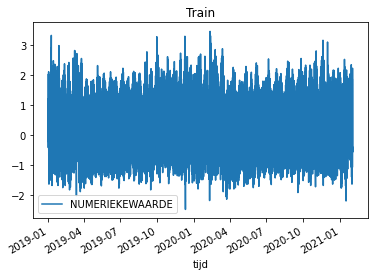

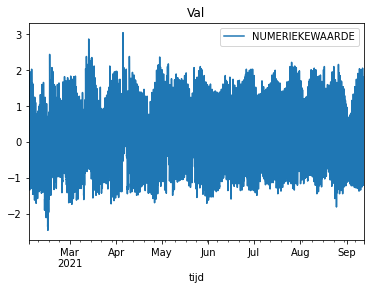

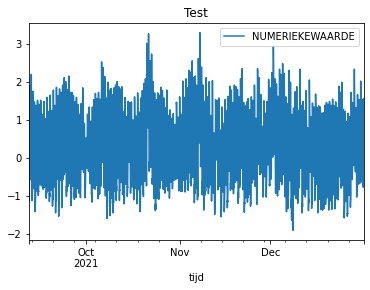

In [ ]:
# Plot train, val and test data

train_df.plot(title='Train')
val_df.plot(title='Val')
test_df.plot(title='Test')

In [ ]:
# Define generator

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window_test = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[275:275+multi_window.total_window_size]),
                           np.array(train_df[400:400+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 720, 1)
Inputs shape: (3, 288, 1)
Labels shape: (3, 432, 1)


In [ ]:
multi_window.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='NUMERIEKEWAARDE', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(24, 16))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    # plt.ylabel(f'{plot_col} [normed]')
    plt.ylabel('Water level [normed]', fontsize = 20)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend(loc = 'upper right', fontsize=16)

  plt.xlabel('Timesteps', fontsize=20)

WindowGenerator.plot = plot

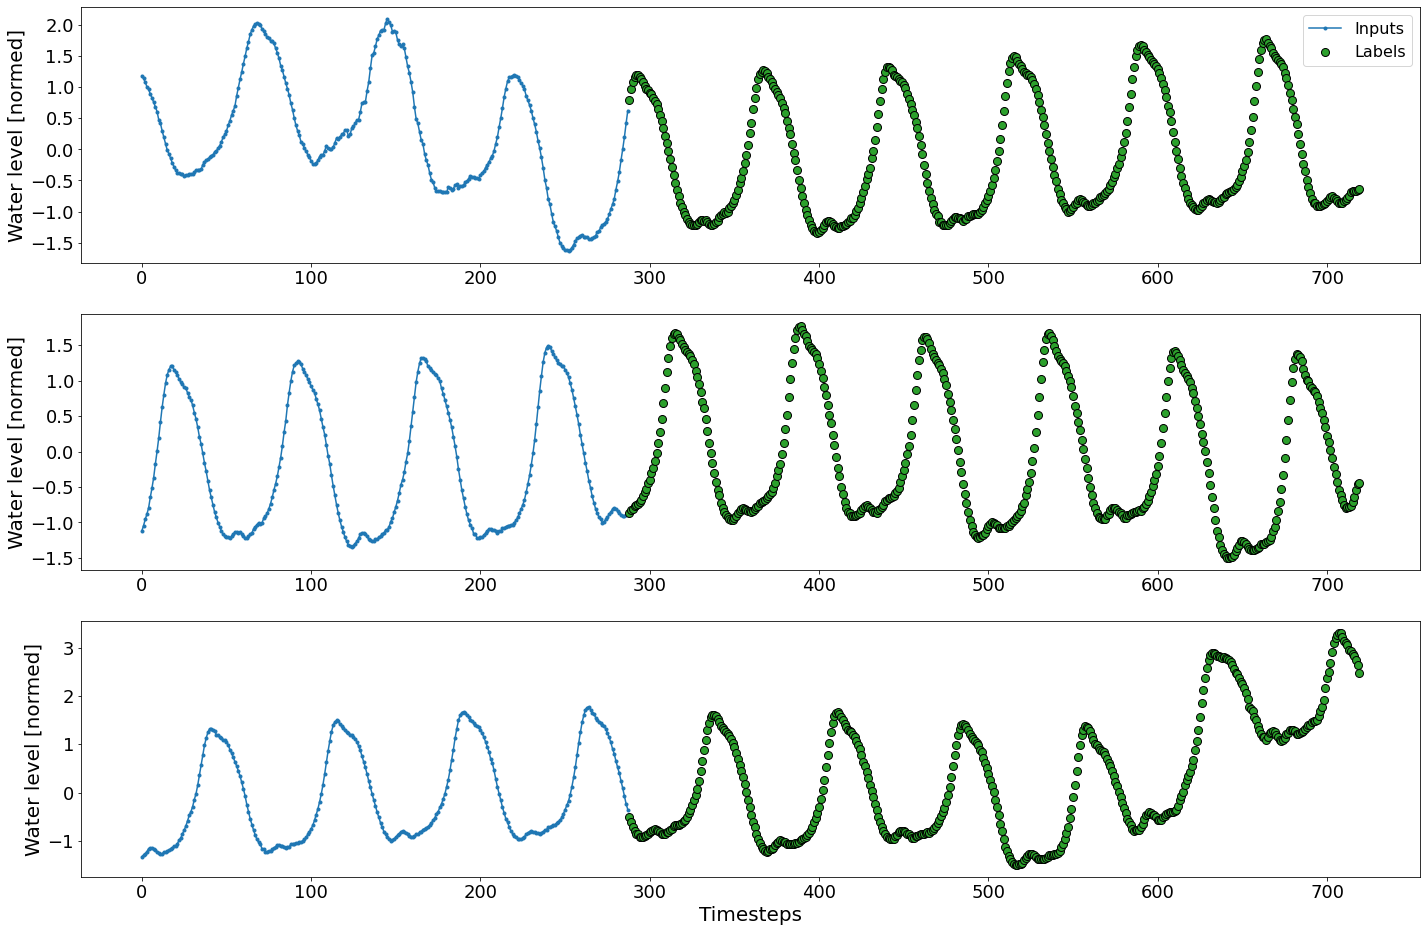

In [ ]:
multi_window.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=128,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 288, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 432, 1), dtype=tf.float32, name=None))

In [ ]:
num_features = 1

# Define the model

lstm_model = tf.keras.models.Sequential([
  # Shape [batch, time, features] => [batch, time, lstm_units]

  # tf.keras.layers.SimpleRNN(64, return_sequences=False),
  # tf.keras.layers.Bidirectional(SimpleRNN(64, return_sequences=False)),

  # tf.keras.layers.GRU(64, return_sequences=True),
  # tf.keras.layers.Bidirectional(GRU(64, return_sequences=False)),

  # tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Bidirectional(LSTM(64, return_sequences=False)),

  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),

  # Shape => [batch, out_steps, features].
  tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', lstm_model(multi_window.example[0]).shape)

Input shape: (128, 288, 1)
Output shape: (128, 432, 1)


In [ ]:
# Define keras compatible R2 function
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Thesis/Model" + str(model_vers) + "/model.h5", 
                                      monitor='val_loss', 
                                      mode='min', 
                                      verbose=1, 
                                      save_best_only=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0005, clipvalue=0.5),
                metrics=[tf.metrics.MeanAbsoluteError(), 
                        tf.keras.metrics.RootMeanSquaredError(), 
                        coeff_determination]
                )

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,
                                model_checkpoint]
                      )
  return history

In [ ]:
# Fit model

history = compile_and_fit(lstm_model, multi_window)

train_performance = {}
val_performance = {}
performance = {}
train_performance['LSTM'] = lstm_model.evaluate(multi_window.train)
val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test)

Epoch 1/25
869/869 [==============================] - ETA: 0s - loss: 0.3571 - mean_absolute_error: 0.4621 - root_mean_squared_error: 0.5975 - coeff_determination: 0.6429
Epoch 1: val_loss improved from inf to 0.24964, saving model to /content/drive/MyDrive/Thesis/Model8.3/model.h5
869/869 [==============================] - 305s 347ms/step - loss: 0.3571 - mean_absolute_error: 0.4621 - root_mean_squared_error: 0.5975 - coeff_determination: 0.6429 - val_loss: 0.2496 - val_mean_absolute_error: 0.3806 - val_root_mean_squared_error: 0.4996 - val_coeff_determination: 0.7360
Epoch 2/25
869/869 [==============================] - ETA: 0s - loss: 0.3090 - mean_absolute_error: 0.4244 - root_mean_squared_error: 0.5558 - coeff_determination: 0.6911
Epoch 2: val_loss improved from 0.24964 to 0.24771, saving model to /content/drive/MyDrive/Thesis/Model8.3/model.h5
869/869 [==============================] - 298s 343ms/step - loss: 0.3090 - mean_absolute_error: 0.4244 - root_mean_squared_error: 0.5558

In [ ]:
# Load latest checkpoint

from keras.models import load_model
lstm_model = load_model("/content/drive/MyDrive/Thesis/Model" + str(model_vers) + "/model.h5", custom_objects={"coeff_determination":coeff_determination})

In [ ]:
# Check if model properly loaded

train_performance = {}
val_performance = {}
performance = {}
train_performance['LSTM'] = lstm_model.evaluate(multi_window.train)
val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test)

120/120 [==============================] - 6s 45ms/step - loss: 0.2439 - mean_absolute_error: 0.3771 - root_mean_squared_error: 0.4938 - coeff_determination: 0.7331


In [ ]:
# Stack three slices, the length of the total window.

example_window_test = tf.stack([np.array(test_df[:multi_window_test.total_window_size]),
                           np.array(test_df[100:100+multi_window_test.total_window_size]),
                           np.array(test_df[300:300+multi_window_test.total_window_size])])

example_inputs_test, example_labels_test = multi_window_test.split_window(example_window_test)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window_test.shape}')
print(f'Inputs shape: {example_inputs_test.shape}')
print(f'Labels shape: {example_labels_test.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 720, 1)
Inputs shape: (3, 288, 1)
Labels shape: (3, 432, 1)


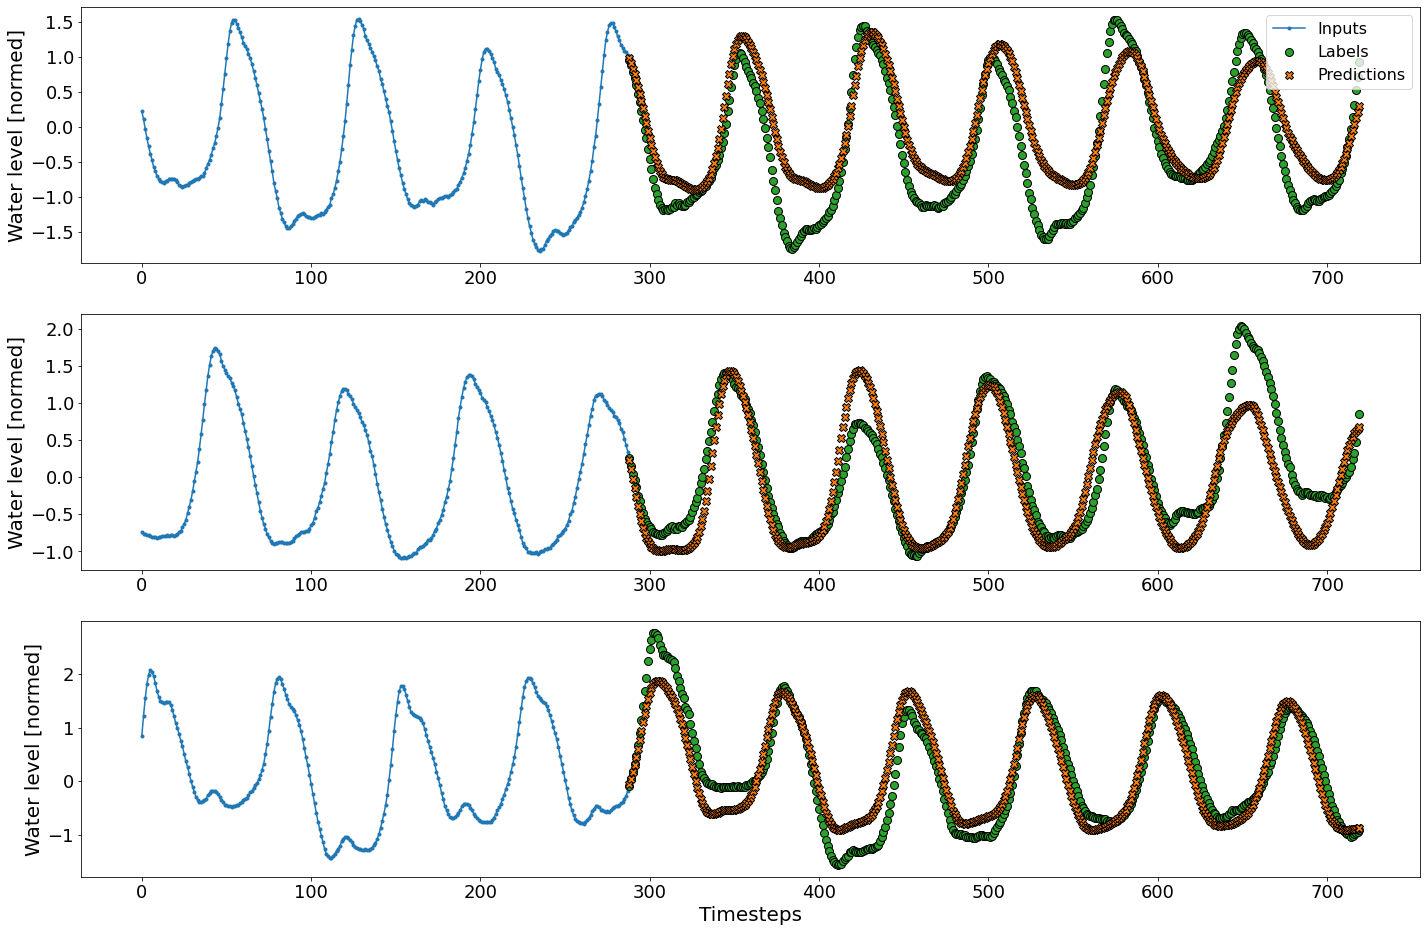

In [ ]:
multi_window_test.plot(lstm_model)

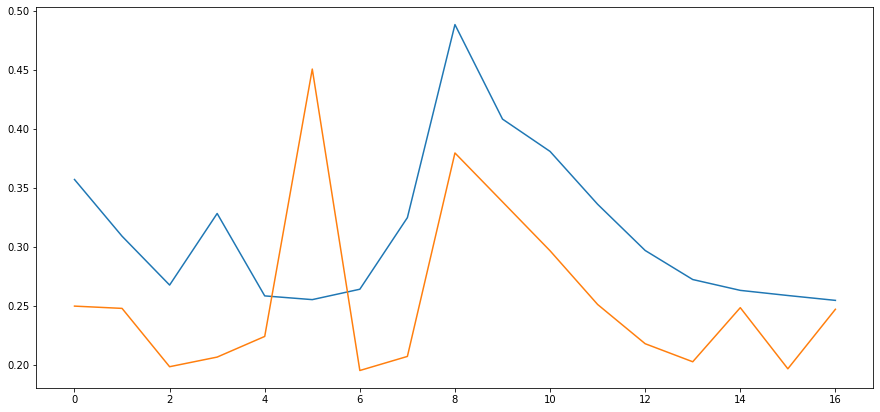

In [ ]:
# Plot loss

loss_per_epoch = history.history['loss']
val_loss_per_epoch = history.history['val_loss']
plt.figure(figsize=(15, 7))
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.plot(val_loss_per_epoch)

In [ ]:
# Make predictions

n_windows = floor((len(test_df) - IN_STEPS) / OUT_STEPS)

def make_predictions():
  preds = []
  for i in range(n_windows):
    if i == 0:
      test_win_start = 0
    if i >= 1:
      test_win_start = i * OUT_STEPS
    test_win_end = test_win_start + IN_STEPS
    test2 = np.array(test_df[test_win_start:test_win_end], dtype=np.float32)
    test2 = np.expand_dims(test2, 0)
    test_pred_buff = lstm_model.predict(test2)
    preds = np.append(preds, test_pred_buff)
    print('Making predictions on window ' + str(i+1) + ' ' + str((test_win_start, test_win_end)) + '...')
  return preds

test_pred = make_predictions()

Making predictions on window 1 (0, 288)...
Making predictions on window 2 (432, 720)...
Making predictions on window 3 (864, 1152)...
Making predictions on window 4 (1296, 1584)...
Making predictions on window 5 (1728, 2016)...
Making predictions on window 6 (2160, 2448)...
Making predictions on window 7 (2592, 2880)...
Making predictions on window 8 (3024, 3312)...
Making predictions on window 9 (3456, 3744)...
Making predictions on window 10 (3888, 4176)...
Making predictions on window 11 (4320, 4608)...
Making predictions on window 12 (4752, 5040)...
Making predictions on window 13 (5184, 5472)...
Making predictions on window 14 (5616, 5904)...
Making predictions on window 15 (6048, 6336)...
Making predictions on window 16 (6480, 6768)...
Making predictions on window 17 (6912, 7200)...
Making predictions on window 18 (7344, 7632)...
Making predictions on window 19 (7776, 8064)...
Making predictions on window 20 (8208, 8496)...
Making predictions on window 21 (8640, 8928)...
Making p

In [ ]:
# Inverse scale

test_true = test_df.NUMERIEKEWAARDE[IN_STEPS:].values

test_true_inv = test_true * float(train_std) + float(train_mean)
test_pred_inv = test_pred * float(train_std) + float(train_mean)

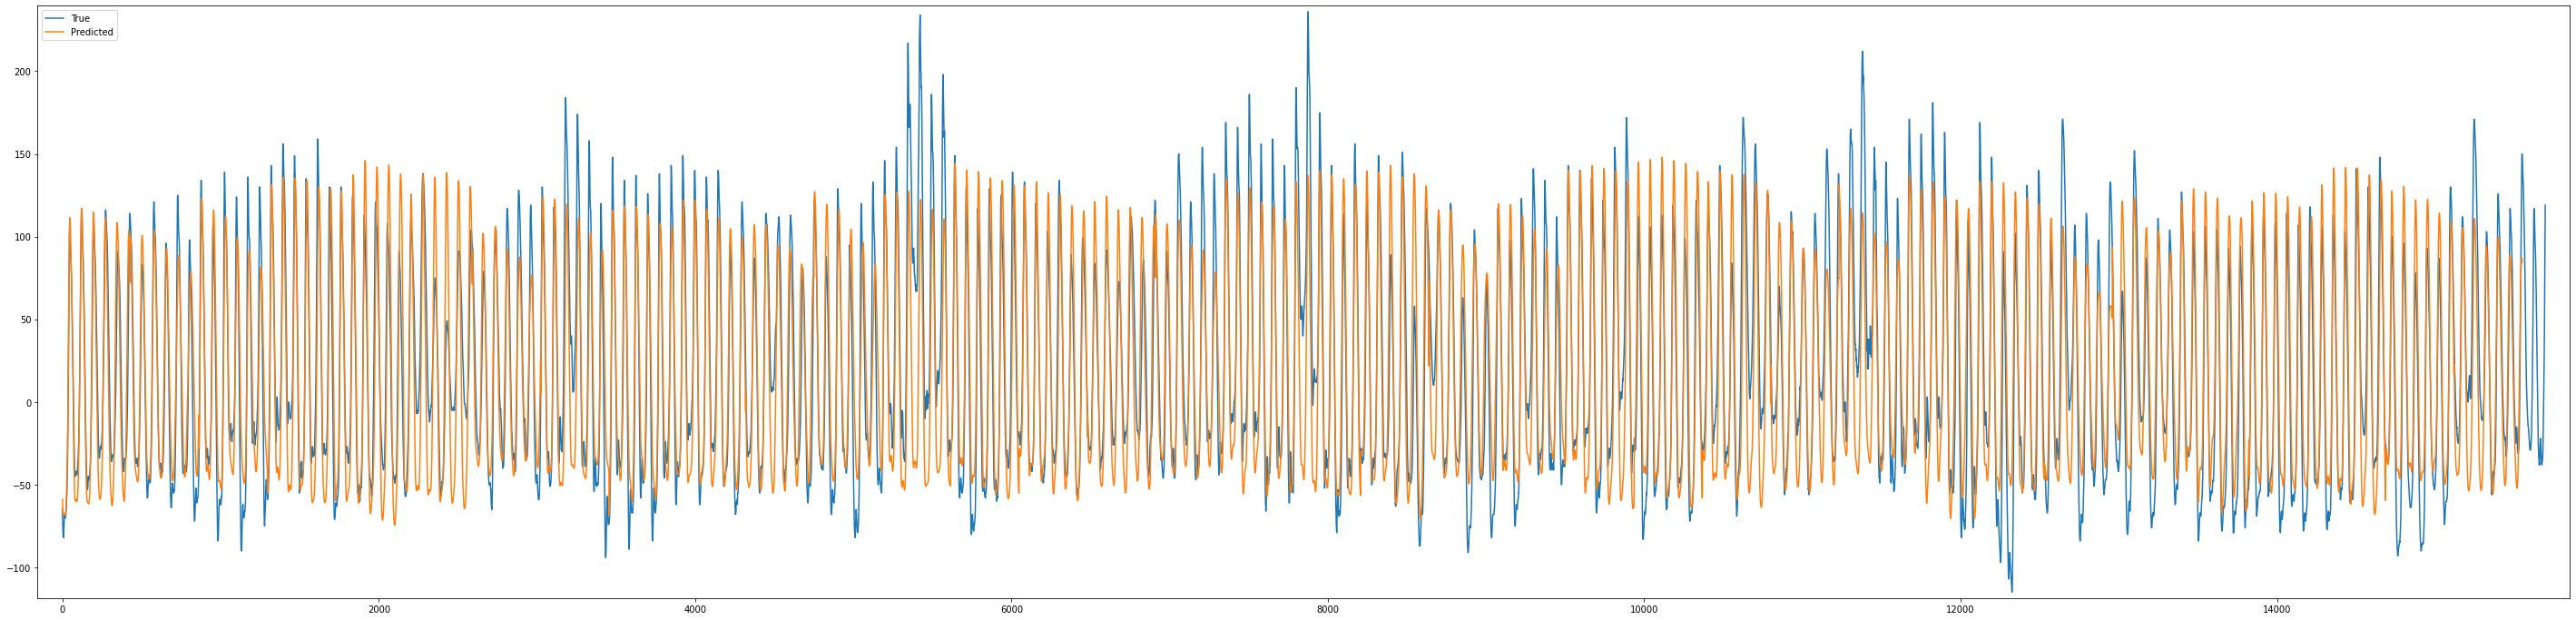

In [ ]:
# Plot predictions vs. true values

true_half1 = 8000

plt.figure(figsize=(30, 7))
plt.margins(x=.01, y=.01)
plt.plot(test_true_inv[:true_half1], label = 'True', linewidth=3)
plt.plot(test_pred_inv[:true_half1], label = 'Predicted', linewidth=2)
plt.ylabel('Water level [cm]', fontsize = 30)
plt.xlabel('Time steps [10 m]', fontsize = 30, labelpad=20)
# plt.xlabel(' ', fontsize = 30)
plt.xticks(fontsize=28)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize=28)
plt.ylim(-120,250)
plt.tick_params(length=15, width=3)
plt.legend(loc="best", fontsize = 28)

plt.figure(figsize=(30, 7))
plt.margins(x=.01, y=.01)
plt.plot(test_true_inv[true_half1+1:-test_buffer], label = 'True', linewidth=3)
plt.plot(test_pred_inv[true_half1+1:], label = 'Predicted', linewidth=2)
plt.ylabel('Water level [cm]', fontsize = 30)
plt.xlabel('Time steps + ' + str(true_half1) + ' [10 m]', fontsize = 30, labelpad=20)
plt.xticks(fontsize=28)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize=28)
plt.ylim(-120,250)
plt.tick_params(length=15, width=3)
# plt.legend(loc="best", fontsize = 26)
# plt.legend(loc="upper left")

In [ ]:
# r square function compatible with numpy arrays

def coeff_determination_np(y_true, y_pred):
  SS_res =  np.sum(np.square( y_true-y_pred ))
  SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot) )

In [ ]:
# Calculate performance metrics

print('In steps: ' + str(IN_STEPS))
print('Out steps: ' + str(OUT_STEPS))
print('')

test_buffer = len(test_true_inv) - len(test_pred_inv) 

mse = mean_squared_error(test_true_inv[:-test_buffer], test_pred_inv, squared=True)
rmse = mean_squared_error(test_true_inv[:-test_buffer], test_pred_inv, squared=False)
mae = mean_absolute_error(test_true_inv[:-test_buffer], test_pred_inv)
R2 = coeff_determination_np(test_true_inv[:-test_buffer], test_pred_inv)
print('Test (manual):')
print('MSE: ' + str(round(mse, 3)))
print('RMSE: ' + str(round(rmse, 3)))
print('MAE: ' + str(round(mae, 3)))
print('R2: ' + str(round(R2, 3)))

In steps: 288
Out steps: 432

Test (manual):
MSE: 967.523
RMSE: 31.105
MAE: 23.834
R2: 0.768


In [ ]:
# Tidal harmonic analysis evaluation metrics on test set

df_comb_test = df_comb[df_comb['tijd'] >= '2021-09-11 23:50:00']

true = df_comb_test.NUMERIEKEWAARDE_x
harm = df_comb_test.NUMERIEKEWAARDE_y

harm_rmse = mean_squared_error(true, harm, squared=False)
harm_mae = mean_absolute_error(true, harm)
R2 = coeff_determination_np(true, harm)

print('RMSE: ' + str(harm_rmse))
print('MAE: ' + str(harm_mae))
print('R2: ' + str(R2))

RMSE: 24.085833888370917
MAE: 17.684821261463597
R2: 0.8607437543644885


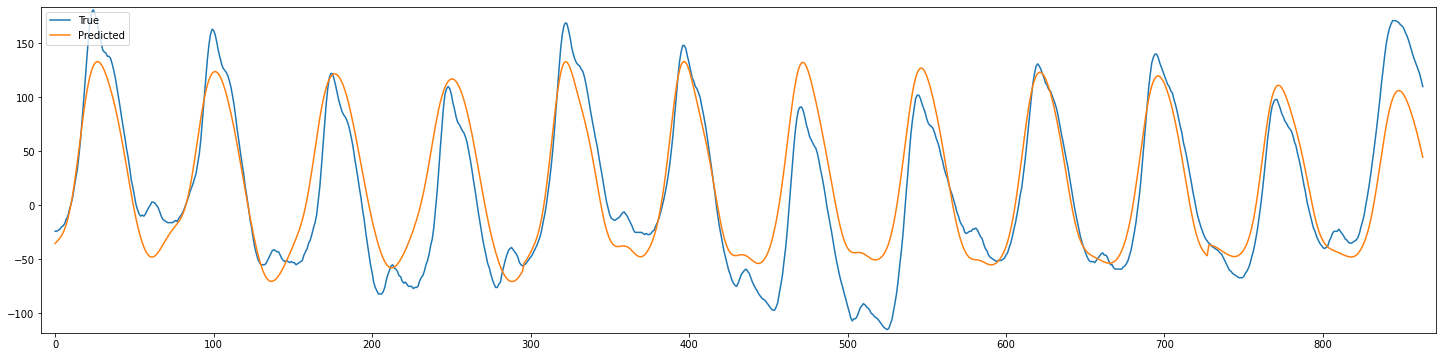

In [ ]:
test_win_start = 11800
test_win_end = test_win_start + 2 * OUT_STEPS

plt.figure(figsize=(25, 6))
plt.margins(x=.01, y=.01)
plt.plot(test_true_inv[test_win_start:test_win_end], label = 'True')
plt.plot(test_pred_inv[test_win_start:test_win_end], label = 'Predicted')
plt.legend(loc="upper left")